# BIGRE spectrograph spot simulation
*A. Bolton, 2023 Sep/Oct*

*This notebook investigates the effects of changing spectrograph aperture size and shape on
the bigre MLA spots delivered to the spectrograph detector.*

In the case of a bigre MLA that samples the diffraction-limited telescope PSF well, the beam profile
in the spectrograph will be significantly affected by microlens diffraction. (It will not just
be determined by the geometric pupil, since the pupil will be unresolved by the microlenses.)

The result is that the reimaged "microslit" on the spectrograph detector will be affected by greater
light loss and mode truncation in the spectrograph than one would expect from geometric optics alone.

This notebook explores those effects across a range of wavelengths (0.4$\mu$m, 0.8$\mu$m, and 1.6$\mu$m),
a range of spectrograph numerical apertures (f/4, f/8, and f/16), and both circular and square spectrograph
acceptance aperture shapes.

Currently assumes microlens sampling scale of 40mas, physical microlens side length of 0.7mm, and
microslit image compression factor of 35x. The illustrations are created by centering the telescope
PSF with an (x,y) offset of (0.4,0.2) spaxels about the center of a 3x3 spaxel grid. This choice of
offset ensures that all 9 computed microslit images are unique, and not just obtainable from each
other through reflections and rotations.

To show detail, the first image in each section shows the 10$\mu$m detector pixels oversampled
by a factor of 10 (i.e., 1$\mu$m simulated pixels), and the color scale is
logarithmic with 10$^6$ dynamic range down from the brightest pixel across all wavelengths.

To give a better sense of how the spots will appear on the detector, the second image in each
section bins down to the actual 10$\mu$m pixel scale, and uses a color scale with 10$^3$ dynamic range
from the brightest pixel.

The total intensity captured by the 3x3 grid is also printed out in each section for the three
different wavelengths. This value is currently normalized to the original 6.5m aperture, so reflects
combined losses from the secondary obscuration, the spectrograph aperture, and the microslit array.

More fine-grained spaxel-by-spaxel losses going from f/4 to f/8 are printed out at the end of
the notebook.

In [1]:
# Imports:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import poppy
from poppy.poppy_core import PlaneType
import astropy.units as u
import astropy.io.fits as fits
import skimage.measure

In [2]:
# Function to create the bigre optical system:

def make_bigre_sys(diam = 6.5*u.m,           # diameter of primary mirror
                   sec_rad = 0.65*u.m,       # radius of secondary obscuration
                   n_supp = 3,               # number of secondary support struts
                   supp_wid = 0.15*u.m,      # width of secondary support struts
                   npix = 2048,              # number of pixels across pupil
                   pupil_factor = 10,        # beam diameter as multiple of pupil diameter (for unresolved pupil handling)
                   spaxel_arcsec = 0.040,    # spaxel side length in angular units
                   spaxel_size=700.e-6*u.m,  # spaxel side length in physical units
                   xcompression = 35.,       # bigre microslit compression factor
                   fratio_spec = 8.,         # f-ratio of spectrograph
                   specap_shape = 'circle',  # shape of spectrograph acceptance aperture ('square' or 'circle')
                   pix_scale = 1.e-6*u.m,    # desired physical scale of pixels on the detector
                   fov_pixels = 100):        # desired FOV in pixels for detector

    # Computed parameters:
    pupil_diam = pupil_factor * diam                  # full beam diameter
    fl_pri = spaxel_size / (spaxel_arcsec / 206265.)  # focal length of primary mirror
    fratio_pri = fl_pri / diam                        # focal ratio of primary mirror
    fratio_mla = fratio_pri / xcompression            # focal ratio emerging from bigre mla
    pix_per_spax = (spaxel_size / xcompression) / pix_scale # number of pixels sampling a spaxel minislit
    
    # Hardwired parameters:
    oversample = 1    # Oversampling of Fourier modes: force to 1 to avoid confusion.
                      # (We are already buffering around the pupil explicitly.)
    
    # Pack all these into a dictionary for reference:
    par_dict = {'diam': diam,
                'sec_rad': sec_rad,
                'n_supp': n_supp,
                'supp_wid': supp_wid,
                'npix': npix,
                'pupil_factor': pupil_factor,
                'spaxel_arcsec': spaxel_arcsec,
                'spaxel_size': spaxel_size,
                'xcompression': xcompression,
                'fratio_spec': fratio_spec,
                'specap_shape': specap_shape,
                'pix_scale': pix_scale,
                'fov_pixels': fov_pixels,
                '_pupil_diam': pupil_diam,
                '_fl_pri': fl_pri,
                '_fratio_pri': fratio_pri,
                '_fratio_mla': fratio_mla,
                '_pix_per_spax': pix_per_spax}
    
    # Create optical system:
    osys = poppy.OpticalSystem(pupil_diameter=pupil_diam, npix=npix, oversample=oversample)
    prim_ap = poppy.CircularAperture(radius=diam/2.)
    ttstage = poppy.TipTiltStage(prim_ap, radius=diam/2.)
    osys.add_pupil(ttstage, name='Primary aperture')
    osys.planes[-1].wavefront_display_hint = 'intensity'
    osys.add_pupil(poppy.SecondaryObscuration(secondary_radius=sec_rad, n_supports=n_supp, support_width=supp_wid))
    osys.planes[-1].wavefront_display_hint = 'intensity'
    osys.add_image(poppy.ScalarTransmission(planetype=PlaneType.image, name='Telescope focal plane'))
    osys.add_image(poppy.SquareFieldStop(size=spaxel_arcsec, name='MLA aperture'))
    osys.add_pupil(poppy.ScalarTransmission(planetype=PlaneType.pupil, name='Far-field pupil'))
    osys.planes[-1].wavefront_display_hint = 'intensity'
    if (specap_shape == 'square'):
        osys.add_pupil(poppy.SquareAperture(size=diam*(fratio_mla/fratio_spec)), name='Spectrograph aperture')
    elif (specap_shape == 'circle'):
        osys.add_pupil(poppy.CircularAperture(radius=0.5*diam*(fratio_mla/fratio_spec)), name='Spectrograph aperture')
    else:
        print('Unknown value for specap_shape')
    osys.planes[-1].wavefront_display_hint = 'intensity'
    osys.add_detector(pixelscale=(spaxel_arcsec*u.arcsec)/(pix_per_spax*u.pixel), fov_pixels=fov_pixels)
    osys.par_dict = par_dict
    
    return osys

In [3]:
# Function to create an NxN mosaic of bigre microslit images, using bigre optical system from above:

def calc_box(osys, nbox=3, lam_val=1.0*u.micron, xycen=(0,0)):
    nsub = osys.par_dict['fov_pixels']
    # Reversed ranges below are because we tip/tilt the telescope one way to walk the PSF the other...
    tips = (-(np.arange(nbox) - 0.5 * (nbox-1)) + xycen[0]) * osys.par_dict['spaxel_arcsec']
    tilts = (-(np.arange(nbox) - 0.5 * (nbox-1)) + xycen[1]) * osys.par_dict['spaxel_arcsec']
    big_im = np.full((nbox*nsub,nbox*nsub),0.)
    for j in range(nbox):
        for i in range(nbox):
            #print(j,i)
            osys[0].set_tip_tilt(tips[i],tilts[j])
            out_psf = osys.calc_psf(wavelength=lam_val, display_intermediates=False, return_intermediates=False)
            big_im[j*nsub:(j+1)*nsub,i*nsub:(i+1)*nsub] = out_psf[0].data
    return big_im

### f/4 spectrograph with circular aperture

0.7940832186611203 0.668961246002145 0.4731787672835036


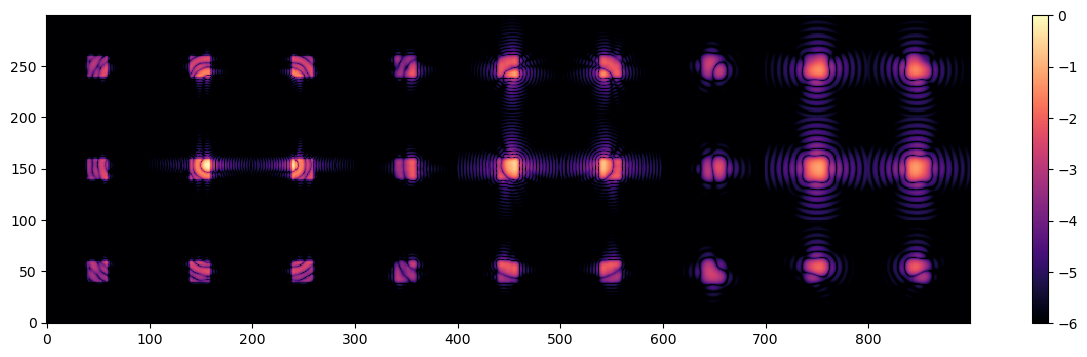

In [4]:
osys = make_bigre_sys(fratio_spec=4., spaxel_arcsec=0.040)
big_im_04 = calc_box(osys, xycen=(.4, .2), lam_val=0.4*u.micron)
big_im_08 = calc_box(osys, xycen=(.4, .2), lam_val=0.8*u.micron)
big_im_16 = calc_box(osys, xycen=(.4, .2), lam_val=1.6*u.micron)
big_im_all = np.hstack([big_im_04, big_im_08, big_im_16])
plt.figure(figsize=(16,4))
plt.imshow(np.log10(big_im_all/big_im_all.max()), origin='lower', cmap='magma',
           interpolation='nearest', vmin=-6, vmax=0)
plt.colorbar()
print(big_im_04.sum(), big_im_08.sum(), big_im_16.sum())

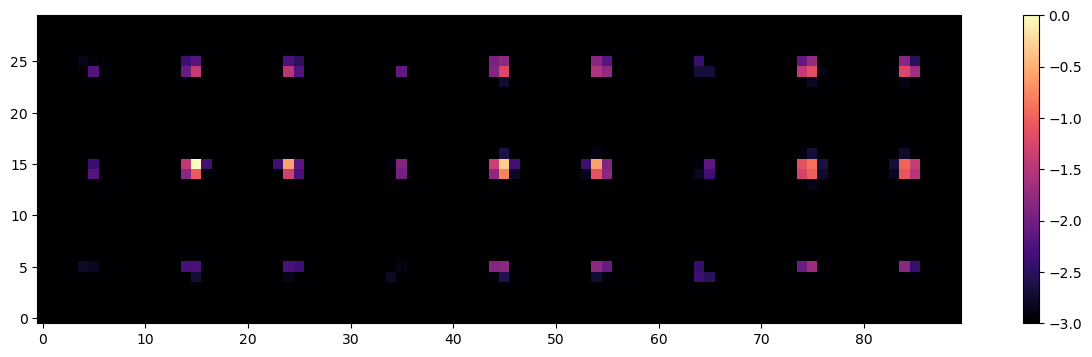

In [5]:
pix_im_all = skimage.measure.block_reduce(big_im_all, block_size=10, func=np.sum)
plt.figure(figsize=(16,4))
plt.imshow(np.log10(pix_im_all/pix_im_all.max()), origin='lower', cmap='magma',
           interpolation='nearest', vmin=-3, vmax=0)
plt.colorbar()

In [6]:
# Tabulate totals in spaxels and in grid:
flux_spax_f4c = skimage.measure.block_reduce(pix_im_all, block_size=10, func=np.sum)
flux_tot_f4c = skimage.measure.block_reduce(flux_spax_f4c, block_size=3, func=np.sum)

### f/8 spectrograph with circular aperture

0.7536834518868547 0.6006477015219547 0.3646070702777194


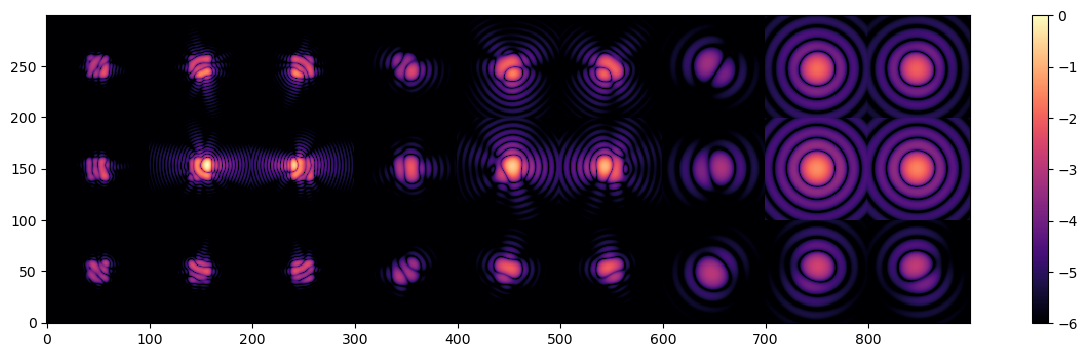

In [7]:
osys = make_bigre_sys(fratio_spec=8., spaxel_arcsec=0.040)
big_im_04 = calc_box(osys, xycen=(.4, .2), lam_val=0.4*u.micron)
big_im_08 = calc_box(osys, xycen=(.4, .2), lam_val=0.8*u.micron)
big_im_16 = calc_box(osys, xycen=(.4, .2), lam_val=1.6*u.micron)
big_im_all = np.hstack([big_im_04, big_im_08, big_im_16])
plt.figure(figsize=(16,4))
plt.imshow(np.log10(big_im_all/big_im_all.max()), origin='lower', cmap='magma',
           interpolation='nearest', vmin=-6, vmax=0)
plt.colorbar()
print(big_im_04.sum(), big_im_08.sum(), big_im_16.sum())

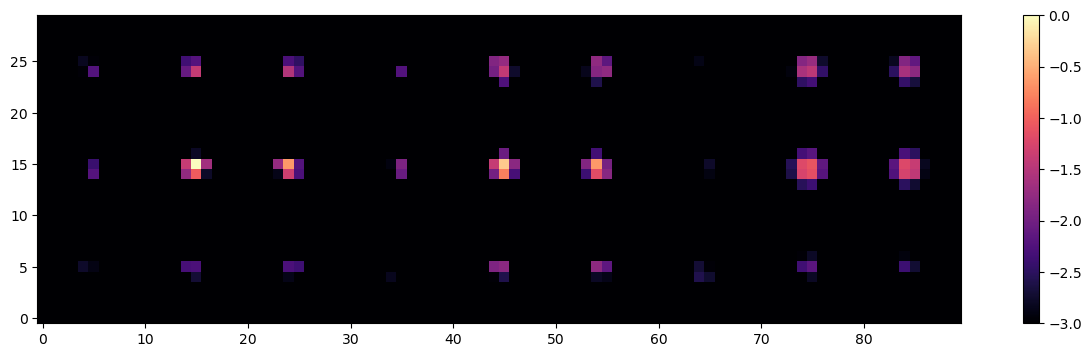

In [8]:
pix_im_all = skimage.measure.block_reduce(big_im_all, block_size=10, func=np.sum)
plt.figure(figsize=(16,4))
plt.imshow(np.log10(pix_im_all/pix_im_all.max()), origin='lower', cmap='magma',
           interpolation='nearest', vmin=-3, vmax=0)
plt.colorbar()

In [9]:
# Tabulate totals in spaxels and in grid:
flux_spax_f8c = skimage.measure.block_reduce(pix_im_all, block_size=10, func=np.sum)
flux_tot_f8c = skimage.measure.block_reduce(flux_spax_f8c, block_size=3, func=np.sum)

### f/16 spectrograph with circular aperture

0.5386919380326246 0.32667042802888274 0.13664875305841492


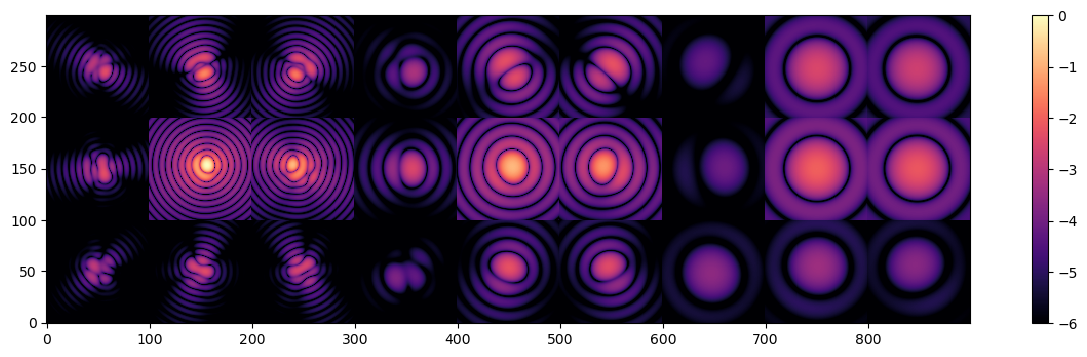

In [10]:
osys = make_bigre_sys(fratio_spec=16., spaxel_arcsec=0.040)
big_im_04 = calc_box(osys, xycen=(.4, .2), lam_val=0.4*u.micron)
big_im_08 = calc_box(osys, xycen=(.4, .2), lam_val=0.8*u.micron)
big_im_16 = calc_box(osys, xycen=(.4, .2), lam_val=1.6*u.micron)
big_im_all = np.hstack([big_im_04, big_im_08, big_im_16])
plt.figure(figsize=(16,4))
plt.imshow(np.log10(big_im_all/big_im_all.max()), origin='lower', cmap='magma',
           interpolation='nearest', vmin=-6, vmax=0)
plt.colorbar()
print(big_im_04.sum(), big_im_08.sum(), big_im_16.sum())

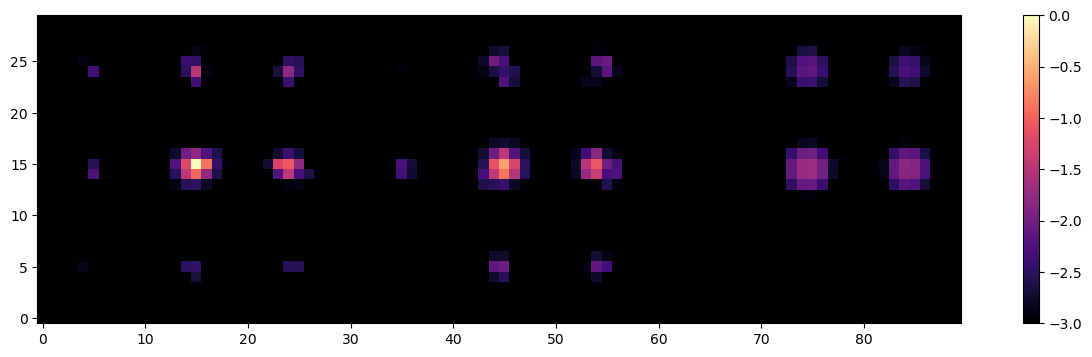

In [11]:
pix_im_all = skimage.measure.block_reduce(big_im_all, block_size=10, func=np.sum)
plt.figure(figsize=(16,4))
plt.imshow(np.log10(pix_im_all/pix_im_all.max()), origin='lower', cmap='magma',
           interpolation='nearest', vmin=-3, vmax=0)
plt.colorbar()

In [12]:
# Tabulate totals in spaxels and in grid:
flux_spax_f16c = skimage.measure.block_reduce(pix_im_all, block_size=10, func=np.sum)
flux_tot_f16c = skimage.measure.block_reduce(flux_spax_f16c, block_size=3, func=np.sum)

### f/4 spectrograph with square aperture

0.7944578382744081 0.6707926772845119 0.4770684162996953


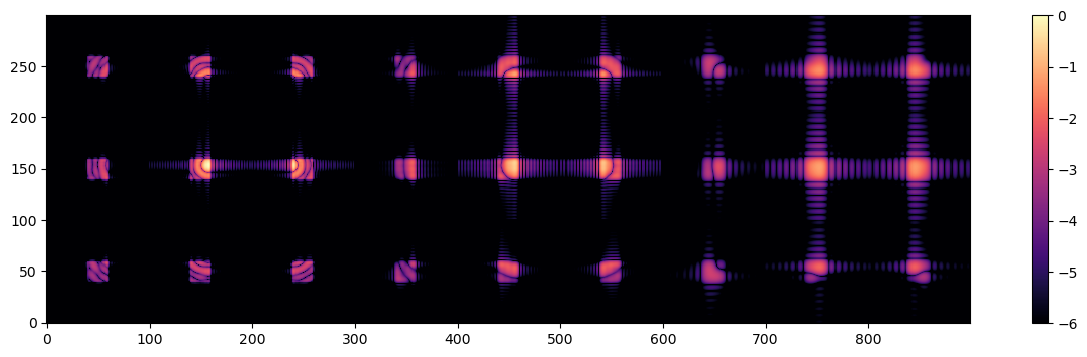

In [13]:
osys = make_bigre_sys(fratio_spec=4., spaxel_arcsec=0.040, specap_shape='square')
big_im_04 = calc_box(osys, xycen=(.4, .2), lam_val=0.4*u.micron)
big_im_08 = calc_box(osys, xycen=(.4, .2), lam_val=0.8*u.micron)
big_im_16 = calc_box(osys, xycen=(.4, .2), lam_val=1.6*u.micron)
big_im_all = np.hstack([big_im_04, big_im_08, big_im_16])
plt.figure(figsize=(16,4))
plt.imshow(np.log10(big_im_all/big_im_all.max()), origin='lower', cmap='magma',
           interpolation='nearest', vmin=-6, vmax=0)
plt.colorbar()
print(big_im_04.sum(), big_im_08.sum(), big_im_16.sum())

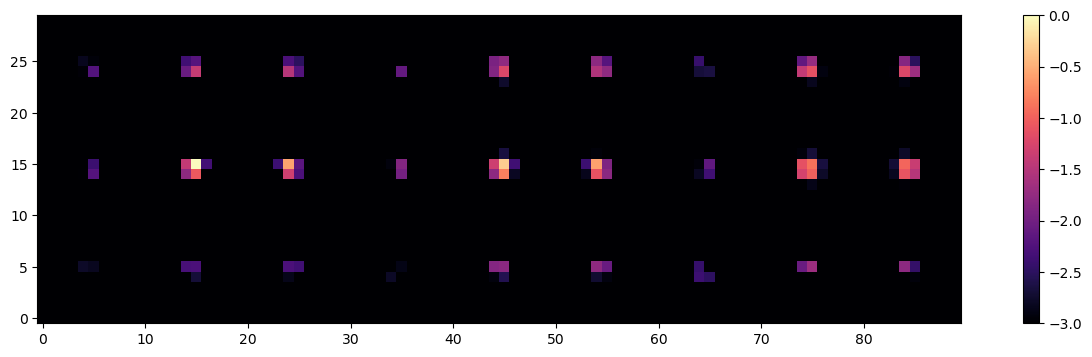

In [14]:
pix_im_all = skimage.measure.block_reduce(big_im_all, block_size=10, func=np.sum)
plt.figure(figsize=(16,4))
plt.imshow(np.log10(pix_im_all/pix_im_all.max()), origin='lower', cmap='magma',
           interpolation='nearest', vmin=-3, vmax=0)
plt.colorbar()

In [15]:
# Tabulate totals in spaxels and in grid:
flux_spax_f4s = skimage.measure.block_reduce(pix_im_all, block_size=10, func=np.sum)
flux_tot_f4s = skimage.measure.block_reduce(flux_spax_f4s, block_size=3, func=np.sum)

### f/8 spectrograph with square aperture

0.7566369947715437 0.6082157470845806 0.3953196095844564


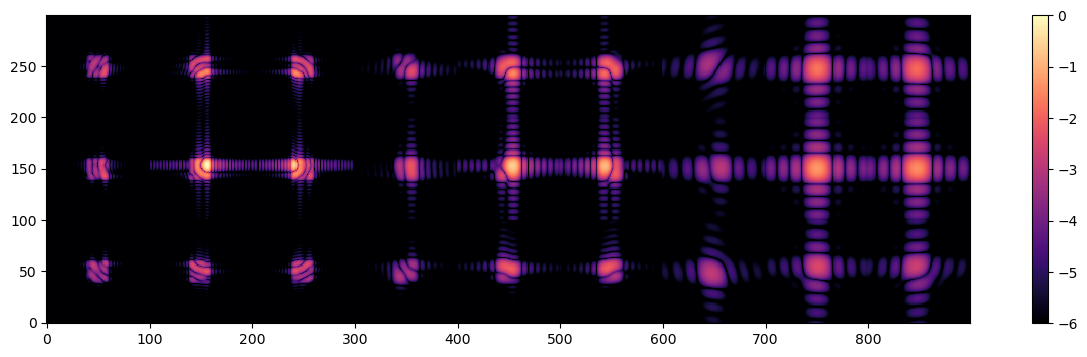

In [16]:
osys = make_bigre_sys(fratio_spec=8., spaxel_arcsec=0.040, specap_shape='square')
big_im_04 = calc_box(osys, xycen=(.4, .2), lam_val=0.4*u.micron)
big_im_08 = calc_box(osys, xycen=(.4, .2), lam_val=0.8*u.micron)
big_im_16 = calc_box(osys, xycen=(.4, .2), lam_val=1.6*u.micron)
big_im_all = np.hstack([big_im_04, big_im_08, big_im_16])
plt.figure(figsize=(16,4))
plt.imshow(np.log10(big_im_all/big_im_all.max()), origin='lower', cmap='magma',
           interpolation='nearest', vmin=-6, vmax=0)
plt.colorbar()
print(big_im_04.sum(), big_im_08.sum(), big_im_16.sum())

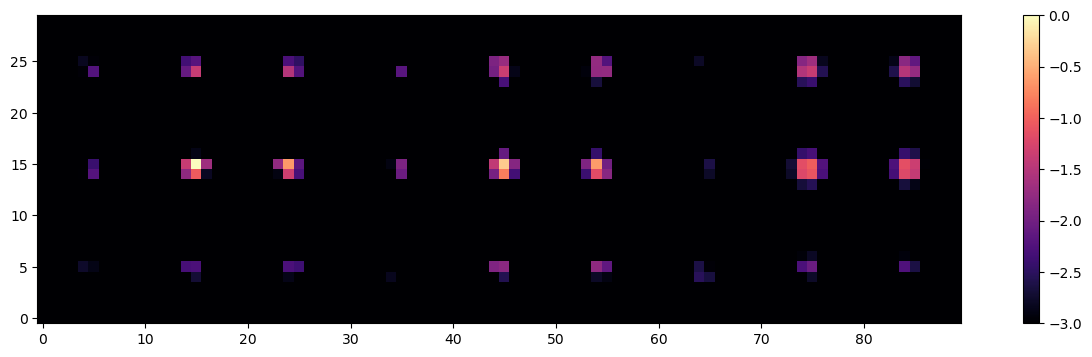

In [17]:
pix_im_all = skimage.measure.block_reduce(big_im_all, block_size=10, func=np.sum)
plt.figure(figsize=(16,4))
plt.imshow(np.log10(pix_im_all/pix_im_all.max()), origin='lower', cmap='magma',
           interpolation='nearest', vmin=-3, vmax=0)
plt.colorbar()

In [18]:
# Tabulate totals in spaxels and in grid:
flux_spax_f8s = skimage.measure.block_reduce(pix_im_all, block_size=10, func=np.sum)
flux_tot_f8s = skimage.measure.block_reduce(flux_spax_f8s, block_size=3, func=np.sum)

### f/16 spectrograph with square aperture

0.6096850752859114 0.3830557157612299 0.1661175897128973


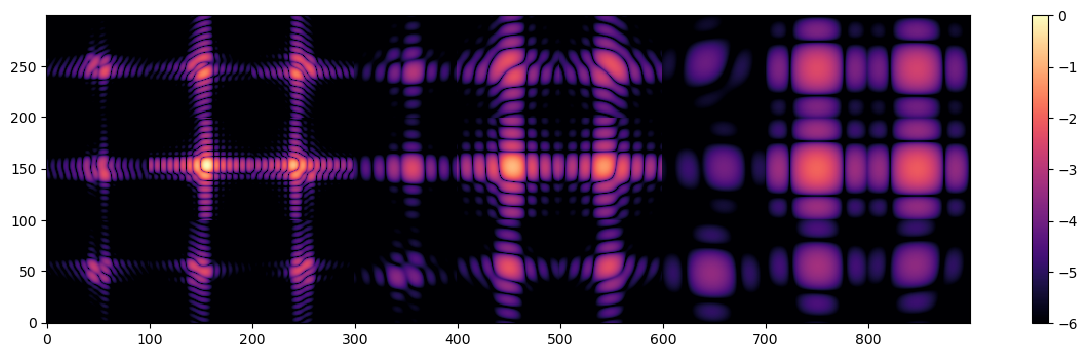

In [19]:
osys = make_bigre_sys(fratio_spec=16., spaxel_arcsec=0.040, specap_shape='square')
big_im_04 = calc_box(osys, xycen=(.4, .2), lam_val=0.4*u.micron)
big_im_08 = calc_box(osys, xycen=(.4, .2), lam_val=0.8*u.micron)
big_im_16 = calc_box(osys, xycen=(.4, .2), lam_val=1.6*u.micron)
big_im_all = np.hstack([big_im_04, big_im_08, big_im_16])
plt.figure(figsize=(16,4))
plt.imshow(np.log10(big_im_all/big_im_all.max()), origin='lower', cmap='magma',
           interpolation='nearest', vmin=-6, vmax=0)
plt.colorbar()
print(big_im_04.sum(), big_im_08.sum(), big_im_16.sum())

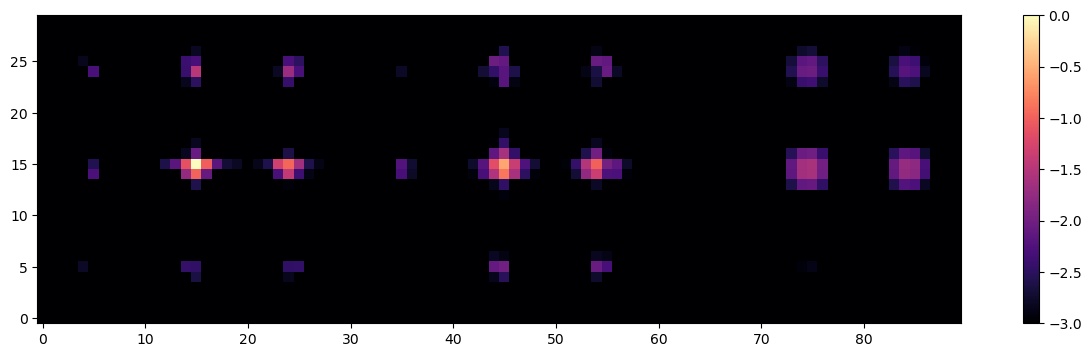

In [20]:
pix_im_all = skimage.measure.block_reduce(big_im_all, block_size=10, func=np.sum)
plt.figure(figsize=(16,4))
plt.imshow(np.log10(pix_im_all/pix_im_all.max()), origin='lower', cmap='magma',
           interpolation='nearest', vmin=-3, vmax=0)
plt.colorbar()

In [21]:
# Tabulate totals in spaxels and in grid:
flux_spax_f16s = skimage.measure.block_reduce(pix_im_all, block_size=10, func=np.sum)
flux_tot_f16s = skimage.measure.block_reduce(flux_spax_f16s, block_size=3, func=np.sum)

### Relative losses going from f/4 to f/8

In [22]:
# Circular, total:
print(1.-flux_tot_f8c.T/flux_tot_f4c.T)

[[0.05087599]
 [0.10211884]
 [0.22945175]]


In [23]:
# Circular, per spaxel:
print(1.-flux_spax_f8c.T/flux_spax_f4c.T)

[[0.06569353 0.04603566 0.04425306]
 [0.0488509  0.03419916 0.06054439]
 [0.04872203 0.10717357 0.0579041 ]
 [0.20733507 0.11874329 0.19157221]
 [0.07744099 0.07620617 0.17606981]
 [0.08365343 0.11870489 0.16623692]
 [0.26817324 0.59382281 0.57280302]
 [0.43756081 0.17646169 0.24289786]
 [0.51802542 0.19438496 0.27749841]]


In [24]:
# Square, total:
print(1.-flux_tot_f8s.T/flux_tot_f4s.T)

[[0.04760585]
 [0.09328803]
 [0.17135657]]


In [25]:
# Square, per spaxel:
print(1.-flux_spax_f8s.T/flux_spax_f4s.T)

[[0.05555372 0.04048392 0.03954683]
 [0.04151387 0.03238749 0.05233485]
 [0.04215539 0.10072563 0.05068893]
 [0.16895311 0.10544262 0.16582932]
 [0.06582231 0.07134467 0.15442532]
 [0.07436999 0.11029968 0.1393953 ]
 [0.20532405 0.50636005 0.48580955]
 [0.36411768 0.12191602 0.18406219]
 [0.43808768 0.13870355 0.2163763 ]]


In [26]:
# F-ratio emerging from the microlens, for reference:
print(osys.par_dict['_fratio_mla'])

15.866538461538461
